In [1]:
# Quelques imports nécéssaires au bon déroulement du projet

#Si vous utilisez le programme sous JupyterLab au lieu de Jupyter Notebook, les étapes suivantes sont à réaliser afin de permettre l'interactivité des graph
#Dans la console, tapez les lignes suivantes (sans les #)
#conda install -y nodejs
#pip install ipympl
#jupyter labextension install @jupyter-widgets/jupyterlab-manager
#jupyter labextension install jupyter-matplotlib
#jupyter nbextension enable --py widgetsnbextension
#Redémarrez JupyterLab

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

### Partie I : Orbite d'un corps autour du soleil

Ici, on va tenter de formaliser l'orbite d'un corps autour d'une planète en passant par les expressions des différentes anomalies.

D'abord, l'anomalie moyenne M peut être calculée facilement en fonction du temps et du moyen mouvement d'une planète. Ces moyens mouvements sont facilement trouvables sur le net.

On va effectuer nos calculs pour la planète Terre afin d'éprouver leur efficacité.

In [2]:
# Fonction calculant l'anomalie moyenne en fonction du temps, du moyen mouvement d'un corps,
#et de l'origine des temps, passage de la planète au périapside
def M(t,m,t0):
    return m*(t-t0)

On peut utiliser cette anomalie moyenne pour déterminer l'anomalie excentrique à un instant t.
Le détail du calcul est trouvable sur la page wikipedia de l'anomalie excentrique.

In [3]:
# Fonction calculant l'anomalie excentrique en fonction de l'anomalie moyenne et de l'excentricité
def E(M,e):
    E = M
    for i in range(0,5):
        E = M + e * np.sin(E)
    return E

De cette anomalie excentrique peut être déduite l'anomalie vrai à l'instant t.

In [4]:
def V(E,e):
    return 2*np.arctan((np.sqrt(1+e)/np.sqrt(1-e))*np.tan(E/2))

Finalement, on utilise cette anomalie vraie pour déterminer la distance du corps à son astre, en fonction du demi grand-axe a.

In [5]:
def R(anom, a, e):
    return ((a*(1-e**2))/(1+e*np.cos(anom)))

Eprouvons maintenant ces méthodes sur l'orbite terrestre. Cette orbite dure 365 jours environ. Cela donne 31536000 secondes.

In [6]:
year=31536000 #s
nbdays=365 #j
time=np.linspace(0,year,nbdays)
ex_terre=0.01671022
a=149.6*10**9 #m
mm=1.9907e-7 #rad/s
t0=0 #s


#Calcul pour la terre
M_terre=M(time,mm,t0)
E_terre=E(M_terre,ex_terre)
V_terre=V(E_terre,ex_terre)
R_terre=R(V_terre,a,ex_terre)

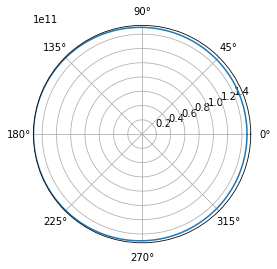

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.plot(V_terre,R_terre)
plt.show()


### Partie 2 : Orbite des planètes du système solaire autour du soleil

##### 1- Ajout des données récoltées

Afin de calculer l'anomalie vraie et la distance du corps à son astre pour toutes les autres planètes, on créé un fichier dataplanets.csv comprenant les données récupérées sur les sites du JET PROPULSION LABORATORY et de la NASA. 

In [79]:
#Ajout des données pour les orbites des différentes planètes 
data=pd.read_csv('dataplanets.csv',delimiter=',' )


#Organisation des données par listes
nom = data.PLANETE.tolist()
demi_gd_axe=data.DEMIGRANDAXE.tolist()
excentricite=data.EXCENTRICITE.tolist()
temps_sec=data.PERIODESEC.tolist()
temps_jours=data.PERIODEJOUR.tolist()
ANGLES=data.ANGLES.tolist()
facteur_164_ans=data.FACTEUR.tolist()
aphelie=data.APHELIE.tolist()
Tzero=data.T0.tolist()



##### 2- Estimation des erreurs

Un modèle étant une représentation simplifiée de la réalité, nous avons du faire des choix sur les paramètres à conserver, et ceux à écarter. Ces hypothèses simplificatrices seront annoncées et leur impact mesuré tout au long du projet.
<br>


En premier lieu,nous avons décidé, de considérer les orbites des planètes comme étant toutes sur le plan de l'écliptique et ayant des orbites centrées sur le soleil. Nous allons cependant calculer les différences de position au demi-grand-axe (a) en prenant en compte l'angle de l'orbite de chaque planète (nommé "i" et donnée par rapport au plan de l'écliptique) afin d'estimer l'erreur sur la position des planètes. Pour cela, nous allons appliquer des règles de trigonométrie dans un triangle selon le schéma suivant : 

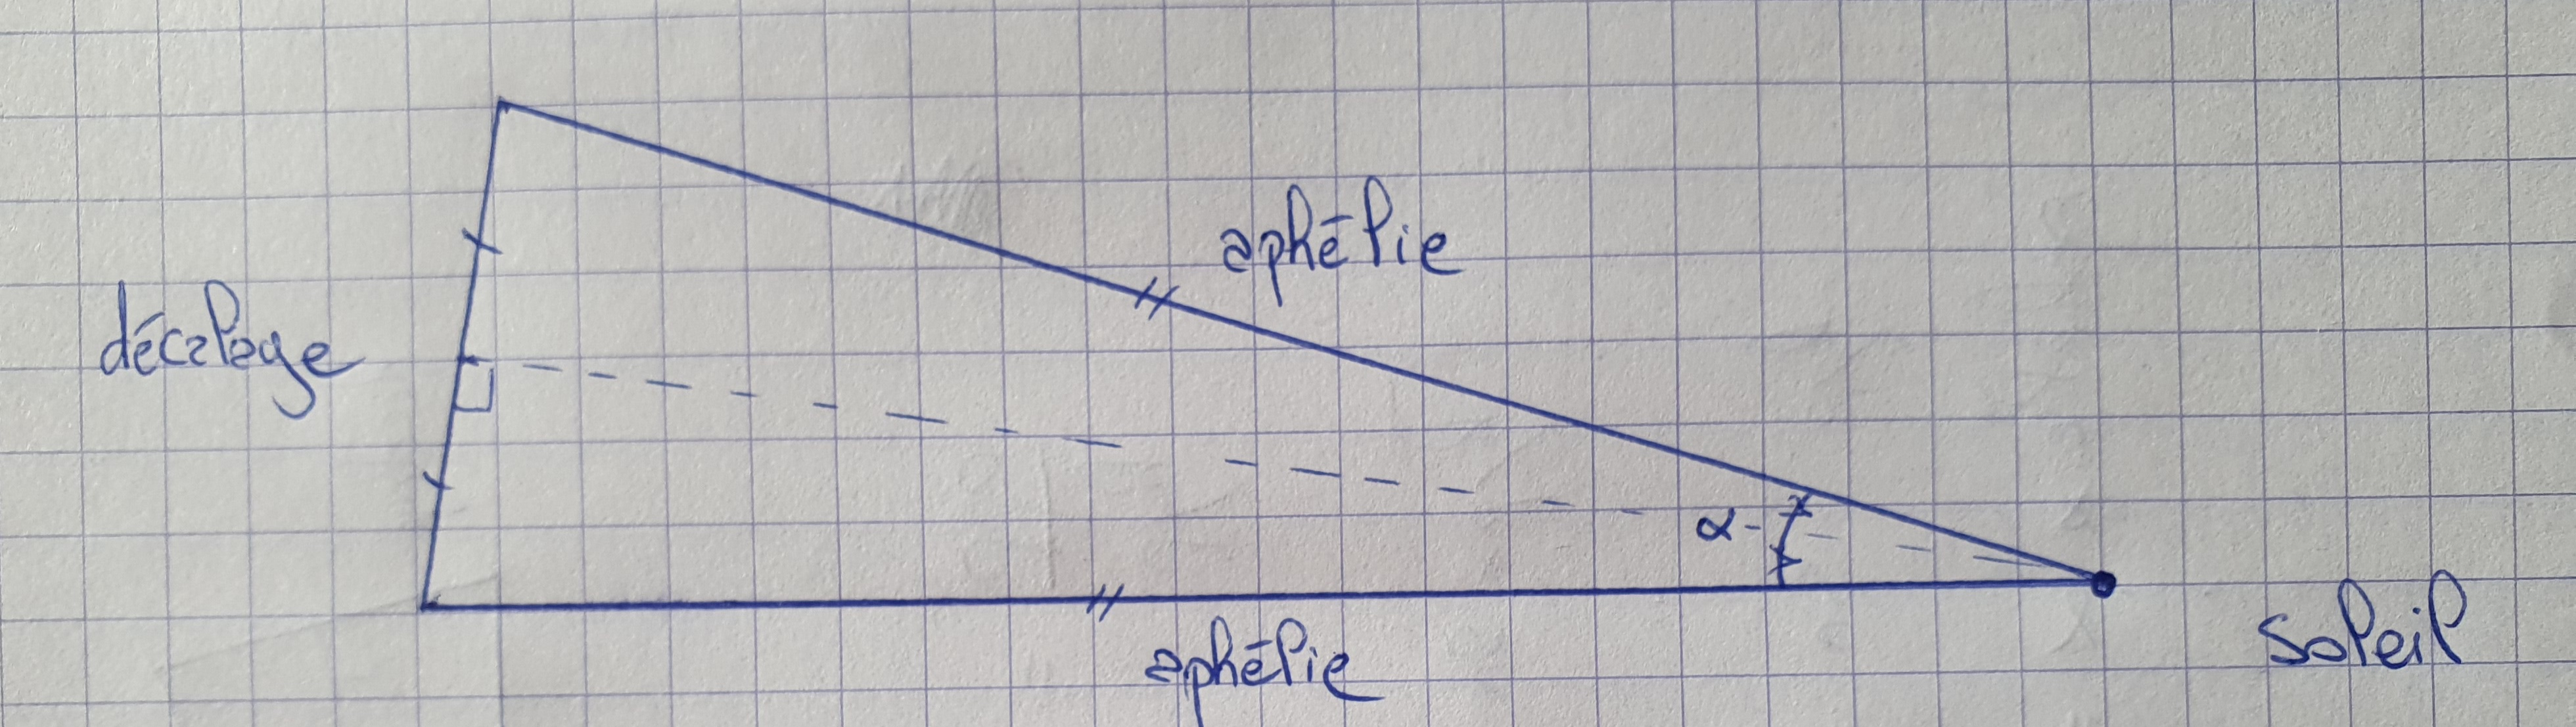

Le demi-grand-axe étant le même quelque soit l'inclinaison de l'orbite. On applique donc la formule suivante : 
$$
sin(\frac{i}{2})*a=\frac{1}{2}décalage
$$
et donc : 
$$
décalage=2*sin(\frac{i}{2})*a
$$

In [80]:
#Création de notre fonction pour le calcul du décalage
def decal (a,i):
    return abs(2 * np.sin(np.deg2rad(i/2)) * a)


In [81]:
#Calcul du décalage par planètes 
decal_planetes=[]

for i in range(len(nom)) : 
    decal_planetes.append(decal(demi_gd_axe[i],ANGLES[i]))
    
for i in range(len(nom)):
    print("On obtient pour", nom[i],", un décalage de :",np.round(decal_planetes[i],2), "m")

On obtient pour MERCURE , un décalage de : 7070547959.45 m
On obtient pour VENUS , un décalage de : 6420340385.34 m
On obtient pour TERRE , un décalage de : 0.0 m
On obtient pour MARS , un décalage de : 7558555373.04 m
On obtient pour JUPITER , un décalage de : 17659658256.66 m
On obtient pour SATURNE , un décalage de : 62247242726.18 m
On obtient pour URANUS , un décalage de : 40081279935.23 m
On obtient pour NEPTUNE , un décalage de : 141315372862.1 m


Rapportons maintenant ce décalage au demi-grand-axe afin d'obtenir un ordre d'idée de l'influence de cette simplification sur nos calculs futurs : 


In [11]:
#Calculons le pourcentage de décalage par rapport au demi-grand-axe : 
pourcentages_decal=[]
for i in range(len(nom)):
    pourcentages_decal.append(decal_planetes[i]*100/(demi_gd_axe[i]))

for i in range(len(nom)):
    print("Le décalage représente, pour", nom[i],":",round(pourcentages_decal[i],2), "% de son demi grand axe")

Le décalage représente, pour MERCURE : 12.21 % de son demi grand axe
Le décalage représente, pour VENUS : 5.93 % de son demi grand axe
Le décalage représente, pour TERRE : 0.0 % de son demi grand axe
Le décalage représente, pour MARS : 3.32 % de son demi grand axe
Le décalage représente, pour JUPITER : 2.27 % de son demi grand axe
Le décalage représente, pour SATURNE : 4.36 % de son demi grand axe
Le décalage représente, pour URANUS : 1.4 % de son demi grand axe
Le décalage représente, pour NEPTUNE : 3.14 % de son demi grand axe


L'erreur due à simplification sur le centre de chaque orbite comme étant le barycentre du Soleil doit être également estimée. Pour cela, nous allons calculer l'écart entre le demi-grand-axe et l'aphélie (point de l'orbite le plus éloigné du soleil) 

In [12]:
  
#Calcul de l'erreur par planète
aphelie_planetes=[]
for i in range(len(nom)) : 
    aphelie_planetes.append(abs(aphelie[i])-(demi_gd_axe[i]))
    
pourcentages_aphelie=[]
for i in range(len(nom)):
    pourcentages_aphelie.append(aphelie_planetes[i]*100/(demi_gd_axe[i]))
                            
for i in range(len(nom)):
    print("La différence entre l'aphélie et le demi-grand-axe pour", nom[i],"est de",round(aphelie_planetes[i],2)
          , "m", "soit une erreur de" , round(pourcentages_aphelie[i],2), "%")

La différence entre l'aphélie et le demi-grand-axe pour MERCURE est de 11890768974 m soit une erreur de 20.53 %
La différence entre l'aphélie et le demi-grand-axe pour VENUS est de 690474606 m soit une erreur de 0.64 %
La différence entre l'aphélie et le demi-grand-axe pour TERRE est de 2501680515 m soit une erreur de 1.67 %
La différence entre l'aphélie et le demi-grand-axe pour MARS est de 21256228449 m soit une erreur de 9.33 %
La différence entre l'aphélie et le demi-grand-axe pour JUPITER est de 38257238582 m soit une erreur de 4.92 %
La différence entre l'aphélie et le demi-grand-axe pour SATURNE est de 87785107220 m soit une erreur de 6.15 %
La différence entre l'aphélie et le demi-grand-axe pour URANUS est de 132966459310 m soit une erreur de 4.63 %
La différence entre l'aphélie et le demi-grand-axe pour NEPTUNE est de 47306988109 m soit une erreur de 1.05 %


##### 3- Représentation des orbites

Représentons donc maintenant les orbites des différentes planètes

In [88]:
#Création de la fonction permettant de calculer la position des planètes 
def pos_planete(j,e,a,mm,t0):
    M_tmp = M(j,mm,t0)
    E_tmp = E(M_tmp,e)
    V_tmp = V(E_tmp,e)
    R_tmp = R(V_tmp,a,e)
    x = R_tmp * np.cos(V_tmp)
    y = R_tmp * np.sin(V_tmp)
    return (x,y,0)

In [43]:


#Calcul du moyen mouvement en rad/s pour les différentes planètes
moy_mouv_s=[]
for i in range(len(nom)):
    moy_mouv_s.append((2*np.pi)/temps_sec[i])

#Création des listes pour les valeurs calculées
M_list=[]
E_list=[]
V_list=[]
R_list=[]
T_list=[]


#Remplissage des listes pour le calcul des orbites
for i in range(len(nom)):
    T_list.append(np.linspace(0,int(temps_sec[i]),int(temps_jours[i])))
    M_list.append(M(T_list[i],moy_mouv_s[i],Tzero[i]))
    E_list.append(E(M_list[i],excentricite[i]))
    V_list.append(V(E_list[i],excentricite[i]))
    R_list.append(R(V_list[i],demi_gd_axe[i],excentricite[i]))
    


<IPython.core.display.Javascript object>


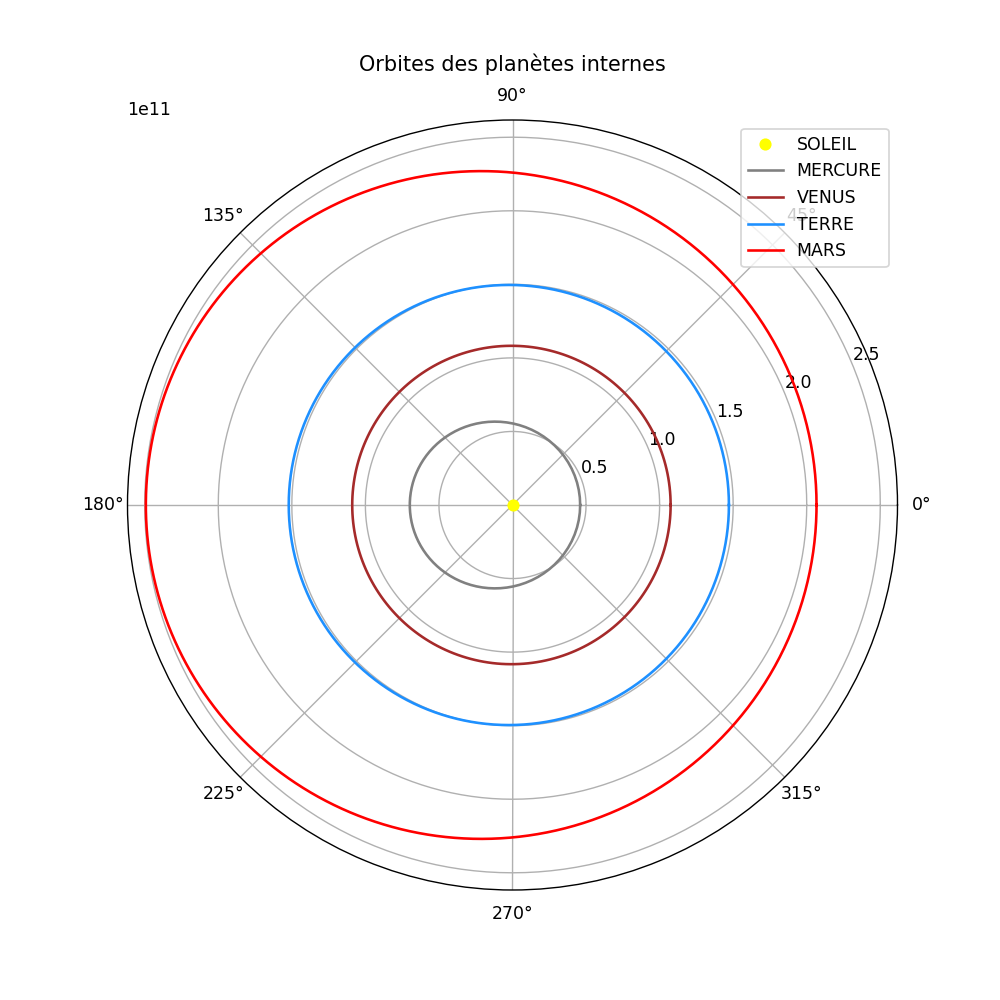

In [89]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')

ax.plot(0,0,'ro',c='yellow',label='SOLEIL')

ax.plot(V_list[0],R_list[0], c='grey', label='MERCURE')
ax.plot(V_list[1],R_list[1], c='brown', label='VENUS')
ax.plot(V_list[2],R_list[2], c='dodgerblue', label='TERRE')
ax.plot(V_list[3],R_list[3], c='red', label='MARS')



plt.title("Orbites des planètes internes")


legend = plt.legend(loc = 'best')


plt.show()

On passe ensuite en coordonnées cartésiennes pour pouvoir calculer la trajectoire de notre sonde et pour plot en 3d afin d'avoir une représentation en perspective.  

In [90]:
#Passage en coordonnées cartésiennes pour plot les orbites en 3d

def pol2cart(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
   
    return(x,y)

#Listes de position pour créer les orbites
MERCURE=pol2cart(R_list[0],V_list[0])
VENUS=pol2cart(R_list[1],V_list[1])
TERRE=pol2cart(R_list[2],V_list[2])
MARS=pol2cart(R_list[3],V_list[3])
JUPITER=pol2cart(R_list[4],V_list[4])
SATURNE=pol2cart(R_list[5],V_list[5])
URANUS=pol2cart(R_list[6],V_list[6])
NEPTUNE=pol2cart(R_list[7],V_list[7])


Créons maintenant une animation permettant de visualiser le déplacement des planètes sur leur orbite , pour cela, commencons par augmenter le nombre de révolution autour du soleil afin de ne pas être limité par les orbites les plus courtes

In [91]:
#Calcul du moyen mouvement en rad/j pour les différentes planètes
moy_mouv=[]
for i in range(len(nom)):
    moy_mouv.append((2*np.pi)/temps_jours[i])
    

def planetes_scatter_int(idx):
    ax.cla()
    mercure=pos_planete(idx,excentricite[0],demi_gd_axe[0],moy_mouv[0],Tzero[0])
    venus=pos_planete(idx,excentricite[1],demi_gd_axe[1],moy_mouv[1],Tzero[1])
    terre=pos_planete(idx,excentricite[2],demi_gd_axe[2],moy_mouv[2],Tzero[2])
    mars=pos_planete(idx,excentricite[3],demi_gd_axe[3],moy_mouv[3],Tzero[3])
    ax.scatter(mercure[0],mercure[1], c='grey', label='MERCURE')
    ax.scatter(venus[0],venus[1], c='brown', label='VENUS')
    ax.scatter(terre[0],terre[1], c='dodgerblue', label='TERRE')
    ax.scatter(mars[0],mars[1], c='red', label='MARS')
    
def planetes_plot_int(idx):
    ax.plot(MERCURE[0],MERCURE[1], c='grey', label='MERCURE')
    ax.plot(VENUS[0],VENUS[1], c='brown', label='VENUS')
    ax.plot(TERRE[0],TERRE[1], c='dodgerblue', label='TERRE')
    ax.plot(MARS[0],MARS[1], c='red', label='MARS')
    
def planetes_scatter_ext(idx):
    ax.cla()
    jupiter=pos_planete(idx,excentricite[4],demi_gd_axe[4],moy_mouv[4],Tzero[4])
    saturne=pos_planete(idx,excentricite[5],demi_gd_axe[5],moy_mouv[5],Tzero[5])
    uranus=pos_planete(idx,excentricite[6],demi_gd_axe[6],moy_mouv[6],Tzero[6])
    neptune=pos_planete(idx,excentricite[7],demi_gd_axe[7],moy_mouv[7],Tzero[7])
    ax.scatter(jupiter[0],jupiter[1], c='orange', label='JUPITER')
    ax.scatter(saturne[0],saturne[1], c='goldenrod', label='SATURNE')
    ax.scatter(uranus[0],uranus[1], c='lightseagreen', label='URANUS')
    ax.scatter(neptune[0],neptune[1], c='skyblue', label='NEPTUNE')
    
def planetes_plot_ext(idx):
    ax.plot(JUPITER[0],JUPITER[1], c='orange', label='JUPITER')
    ax.plot(SATURNE[0],SATURNE[1], c='goldenrod', label='SATURNE')
    ax.plot(URANUS[0],URANUS[1], c='lightseagreen', label='URANUS')
    ax.plot(NEPTUNE[0],NEPTUNE[1], c='skyblue', label='NEPTUNE')

<IPython.core.display.Javascript object>


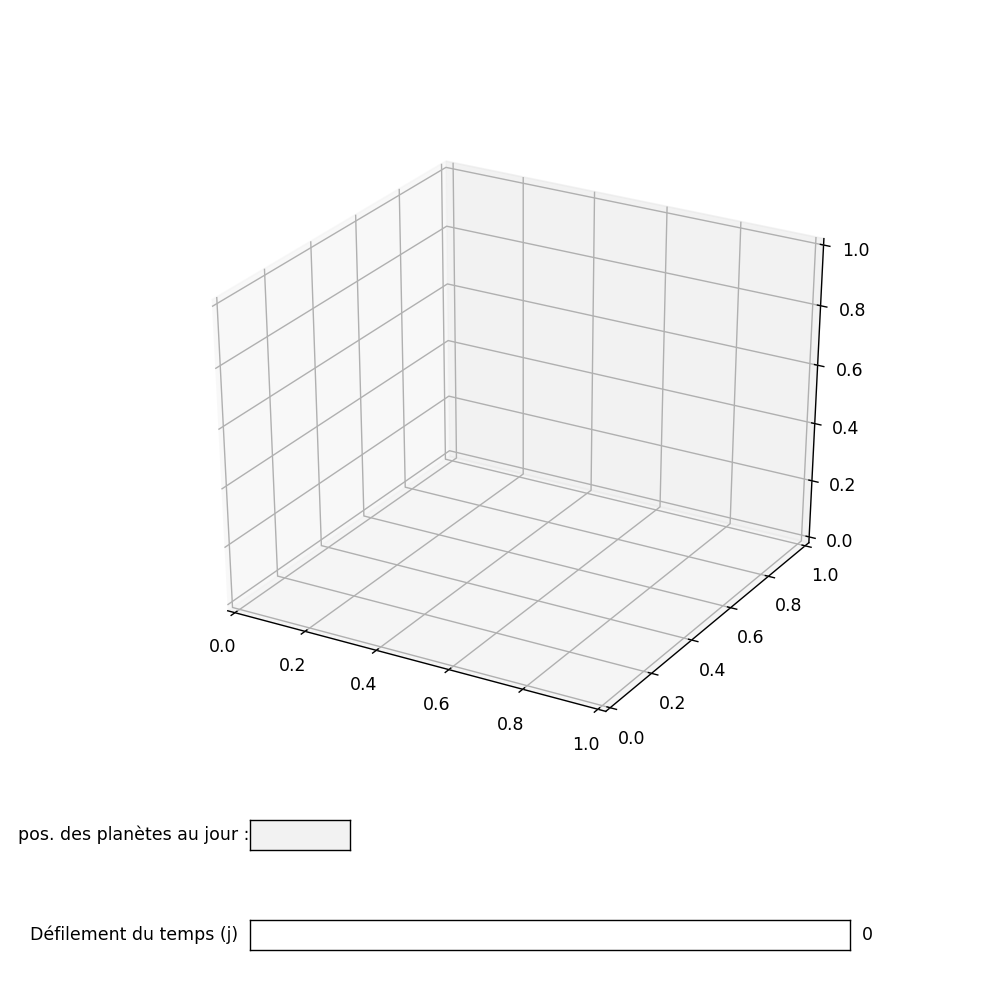

In [92]:
#Utile pour la fonction Slider, textbox et pour rendre les graph interactifs
#Obligatoire pour plot interactif sur JupyterLab
%matplotlib widget 
%matplotlib notebook
from ipywidgets import *
from matplotlib.widgets import Slider
from matplotlib.widgets import TextBox


fig = plt.figure(figsize=(8, 8))
ax= fig.gca(projection='3d')



#Création de la fonction permettant de "rafraichir" la position des planètes

def orbites_int(val):
    idx = int(curseur.val)
    #permet d'effacer les précédentes positions à l'affichage des nouvelles
    #les planètes individuelles
    planetes_scatter_int(idx)
  
    #le soleil
    ax.scatter(0,0,0,'ro',c='yellow',label='SOLEIL')
        
    planetes_plot_int(idx)
    
    plt.title("orbites des planètes intérieures")
    
    fig.canvas.draw_idle()

def valeur_int(text):
    idx = int(text)
    #permet d'effacer les précédentes positions à l'affichage des nouvelles
    #les planètes individuelles
    planetes_scatter_int(idx)
    
    #le soleil
    ax.scatter(0,0,0,'ro',c='yellow',label='SOLEIL')
    
    #les orbites
    planetes_plot_int(idx)
      
    fig.canvas.draw_idle()   
    
    
# Sliders
barre_curseur = plt.axes([0.25, 0.05, 0.6, 0.03])
curseur = Slider(barre_curseur, 'Défilement du temps (j)', 0, 6000, valinit=0, valfmt='%d')
#ici on utilise 6000 comme valeure maximale de manière arbitraire pour plus de faciliter à utiliser le curseur

curseur.on_changed(orbites_int)

#Text box
cadre_text = plt.axes([0.25, 0.15, 0.1, 0.03])
text_box = TextBox(cadre_text, 'pos. des planètes au jour :')
text_box.on_submit(valeur_int)

#Permet d'avoir un peu de place sous le graphique pour les cadres et le titre
plt.subplots_adjust(bottom=0.25)
plt.show()

Affichons maintenant la trajectoire de notre sonde dans le système solaire avec toutes les planètes (maintenir clic droit pour zoomer sur le graphique)

<IPython.core.display.Javascript object>


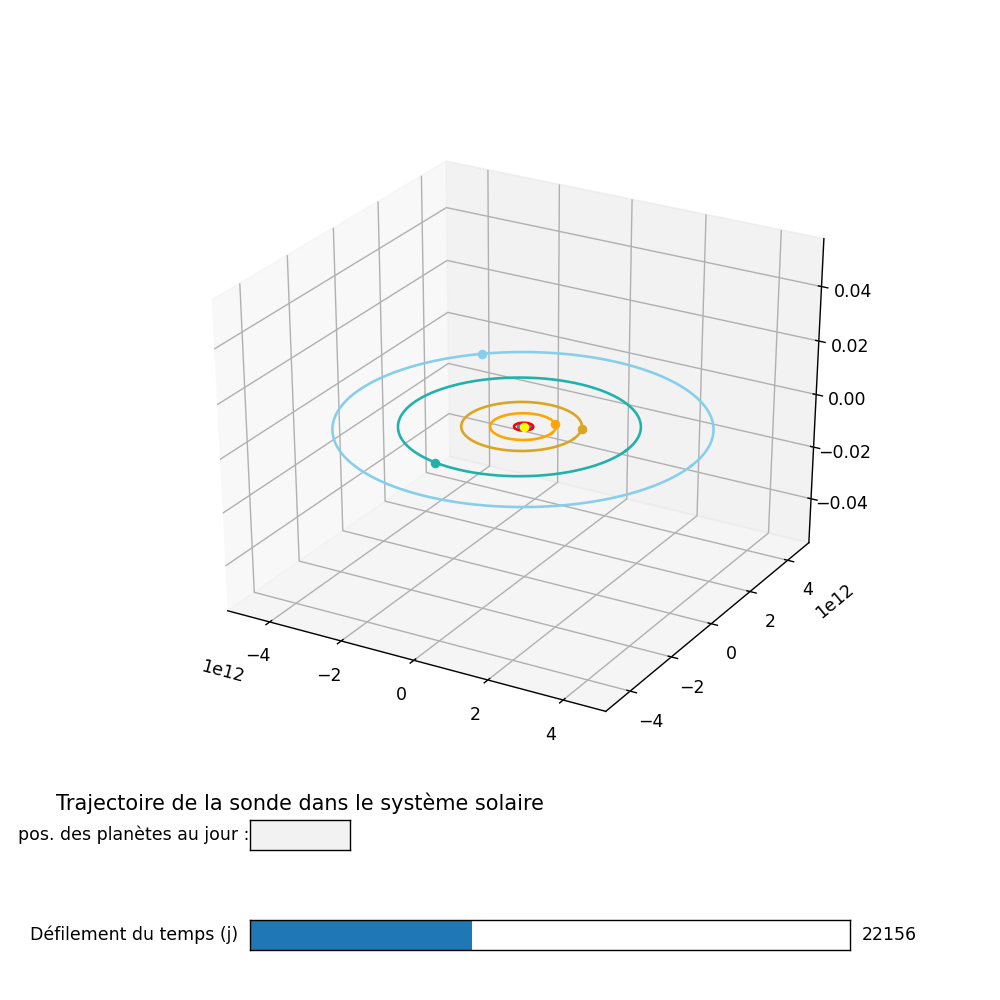

In [93]:
#Obligatoire pour plot interactif sur JupyterLab
%matplotlib widget 

fig = plt.figure(figsize=(8, 8))
ax= fig.gca(projection='3d')

#Création de la fonction permettant de "rafraichir" la position des planètes

def orbites(val):
    idx = int(curseur.val)
    #permet d'effacer les précédentes positions à l'affichage des nouvelles
    planetes_scatter_int(idx)
    planetes_scatter_ext(idx)
    #Placeholder pour la sonde
    
    #le soleil
    ax.scatter(0,0,0,'ro',c='yellow',label='SOLEIL')
    
    #Les orbites des planètes
    planetes_plot_int(idx)
    planetes_plot_ext(idx)
    plt.title("Trajectoire de la sonde dans le système solaire")
    
    fig.canvas.draw_idle()

def valeur(text):
    idx = int(text)
    #permet d'effacer les précédentes positions à l'affichage des nouvelles
    #les planètes individuelles
    planetes_scatter_int(idx)
    planetes_scatter_ext(idx)
    #Placeholder pour la sonde
    
    #le soleil
    ax.scatter(0,0,0,'ro',c='yellow',label='SOLEIL')
    
    #Les orbites des planètes
    planetes_plot_int(idx)
    planetes_plot_ext(idx)
    
    plt.title("Trajectoire de la sonde dans le système solaire")
    
    
    fig.canvas.draw_idle()   
    
    
# Sliders

barre_curseur = plt.axes([0.25, 0.05, 0.6, 0.03])
curseur = Slider(barre_curseur, 'Défilement du temps (j)', 0, 60000, valinit=0, valfmt='%d')
#ici on utilise 6000 comme valeure maximale de manière arbitraire pour plus de faciliter à utiliser le curseur
#La valeur maximale est de 60000 jours, correspondant à une période orbitale de Neptune
curseur.on_changed(orbites)

#Text box
cadre_text = plt.axes([0.25, 0.15, 0.1, 0.03])
text_box = TextBox(cadre_text, 'pos. des planètes au jour :')
text_box.on_submit(valeur)

#Permet d'avoir un peu de place sous le graphique pour les cadres et le titre
plt.subplots_adjust(bottom=0.25)
plt.show()